In [1]:
import torch
import torchvision 
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as ss

In [2]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/train",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/validate/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [18]:
batch_size = 64

data_transforms = {
    
    'train': transforms.Compose([
#         transforms.Resize((512,512)),
        transforms.CenterCrop((336,336)),
        transforms.RandomHorizontalFlip(p = 0.7),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
#         transforms.Resize((512,512)),
#         transforms.CenterCrop((254,254)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ]),
    'test' : transforms.Compose([
        transforms.Resize((360,360)),
#         transforms.CenterCrop((254,254)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [4]:
data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

# data_set={
#         'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
#         'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
#          }

In [5]:
for x,y in data_set['valid']:
    print(x.shape)
    print(y)
    break

torch.Size([3, 360, 360])
0


In [6]:
data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=64,shuffle=True),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=32,shuffle=False),
        }

In [7]:
_ = data_set['valid'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}


In [8]:
cat_to_name

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [9]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True


In [10]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,3)),
    ('out', nn.LogSoftmax(dim=1)),
]))


In [11]:
from tqdm.notebook import tqdm

In [12]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [13]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5, verbose = True)
epochs = 25
valid_loss_min = np.Inf
valid_acc_min = 0

In [13]:
device = 'cuda'

In [14]:
model = model.cuda()

In [16]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(data_loader['train']):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(data_loader['train'])
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(data_loader['train'])
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(data_loader['valid']):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(data_loader['valid'])
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size_512.pt')
            
            valid_loss_min = avg_valid_loss
            
            
        if avg_valid_acc >= valid_acc_min:
            print('Validation Accuracy increase ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_acc_min,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size_512_best_acc.pt')
            
            valid_acc_min = avg_valid_acc
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.383254).   Saving model ...
Validation Accuracy increase (0.000000 --> 0.859664).   Saving model ...
Epoch : 1 Train Loss : 0.519527 Train Acc : 0.801537
Epoch : 1 Valid Loss : 0.383254 Valid Acc : 0.859664


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.383254 --> 0.383010).   Saving model ...
Epoch : 2 Train Loss : 0.347512 Train Acc : 0.876923
Epoch : 2 Valid Loss : 0.383010 Valid Acc : 0.856192


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.308328 Train Acc : 0.894383
Epoch : 3 Valid Loss : 0.728114 Valid Acc : 0.752604


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.276641 Train Acc : 0.904854
Epoch : 4 Valid Loss : 0.564166 Valid Acc : 0.817998


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.383010 --> 0.278690).   Saving model ...
Validation Accuracy increase (0.859664 --> 0.892650).   Saving model ...
Epoch : 5 Train Loss : 0.260100 Train Acc : 0.911216
Epoch : 5 Valid Loss : 0.278690 Valid Acc : 0.892650


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.278690 --> 0.270624).   Saving model ...
Validation Accuracy increase (0.892650 --> 0.899884).   Saving model ...
Epoch : 6 Train Loss : 0.238876 Train Acc : 0.917573
Epoch : 6 Valid Loss : 0.270624 Valid Acc : 0.899884


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.228211 Train Acc : 0.922873
Epoch : 7 Valid Loss : 0.328314 Valid Acc : 0.886863


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.270624 --> 0.216511).   Saving model ...
Validation Accuracy increase (0.899884 --> 0.920139).   Saving model ...
Epoch : 8 Train Loss : 0.214153 Train Acc : 0.927599
Epoch : 8 Valid Loss : 0.216511 Valid Acc : 0.920139


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.200921 Train Acc : 0.932364
Epoch : 9 Valid Loss : 0.267389 Valid Acc : 0.902778


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.216511 --> 0.188012).   Saving model ...
Validation Accuracy increase (0.920139 --> 0.934606).   Saving model ...
Epoch : 10 Train Loss : 0.203613 Train Acc : 0.933028
Epoch : 10 Valid Loss : 0.188012 Valid Acc : 0.934606


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.188446 Train Acc : 0.935422
Epoch : 11 Valid Loss : 0.204899 Valid Acc : 0.929688


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.188012 --> 0.163313).   Saving model ...
Validation Accuracy increase (0.934606 --> 0.935185).   Saving model ...
Epoch : 12 Train Loss : 0.189040 Train Acc : 0.936757
Epoch : 12 Valid Loss : 0.163313 Valid Acc : 0.935185


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.178878 Train Acc : 0.938755
Epoch : 13 Valid Loss : 0.205990 Valid Acc : 0.931134


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.180951 Train Acc : 0.939666
Epoch : 14 Valid Loss : 1.000225 Valid Acc : 0.798322


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.166648 Train Acc : 0.942054
Epoch : 15 Valid Loss : 0.231646 Valid Acc : 0.906829


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.167860 Train Acc : 0.942095
Epoch : 16 Valid Loss : 0.371009 Valid Acc : 0.879630


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.165193 Train Acc : 0.944986
Epoch : 17 Valid Loss : 0.211774 Valid Acc : 0.927662


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 18 Train Loss : 0.154844 Train Acc : 0.946728
Epoch : 18 Valid Loss : 0.202800 Valid Acc : 0.931424


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.163313 --> 0.133377).   Saving model ...
Validation Accuracy increase (0.935185 --> 0.949653).   Saving model ...
Epoch : 19 Train Loss : 0.118719 Train Acc : 0.961147
Epoch : 19 Valid Loss : 0.133377 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.102354 Train Acc : 0.966025
Epoch : 20 Valid Loss : 0.140356 Valid Acc : 0.948495


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.092128 Train Acc : 0.969362
Epoch : 21 Valid Loss : 0.144020 Valid Acc : 0.949363


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.089979 Train Acc : 0.970196
Epoch : 22 Valid Loss : 0.143603 Valid Acc : 0.948206


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.949653 --> 0.951100).   Saving model ...
Epoch : 23 Train Loss : 0.088234 Train Acc : 0.970047
Epoch : 23 Valid Loss : 0.142183 Valid Acc : 0.951100


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.086520 Train Acc : 0.971621
Epoch : 24 Valid Loss : 0.142159 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Epoch : 25 Train Loss : 0.081650 Train Acc : 0.973049
Epoch : 25 Valid Loss : 0.147924 Valid Acc : 0.948785


Text(0, 0.5, 'Accuracy')

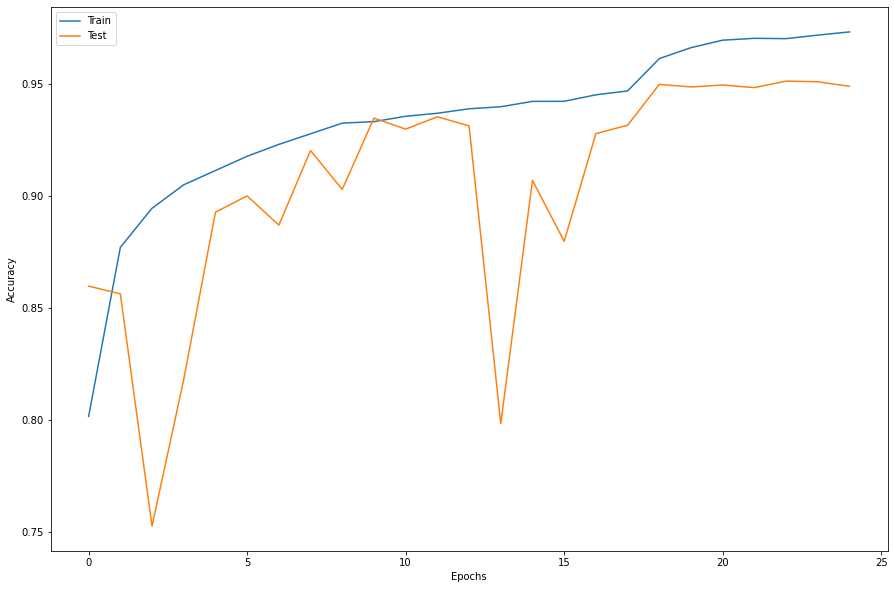

In [17]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

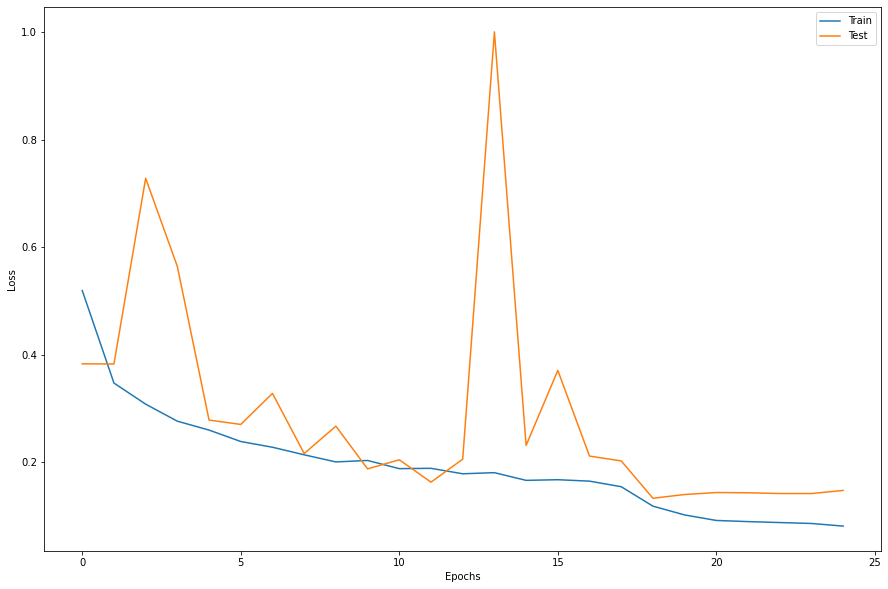

In [18]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [15]:
model.load_state_dict(state_dict=torch.load("./DenseNet_size_512.pt")['model_state_dict'])

<All keys matched successfully>

In [16]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [33]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(data_loader['valid'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

In [34]:
import pandas as pd
import seaborn as sns

Text(0.5, 69.0, 'Predicted label')

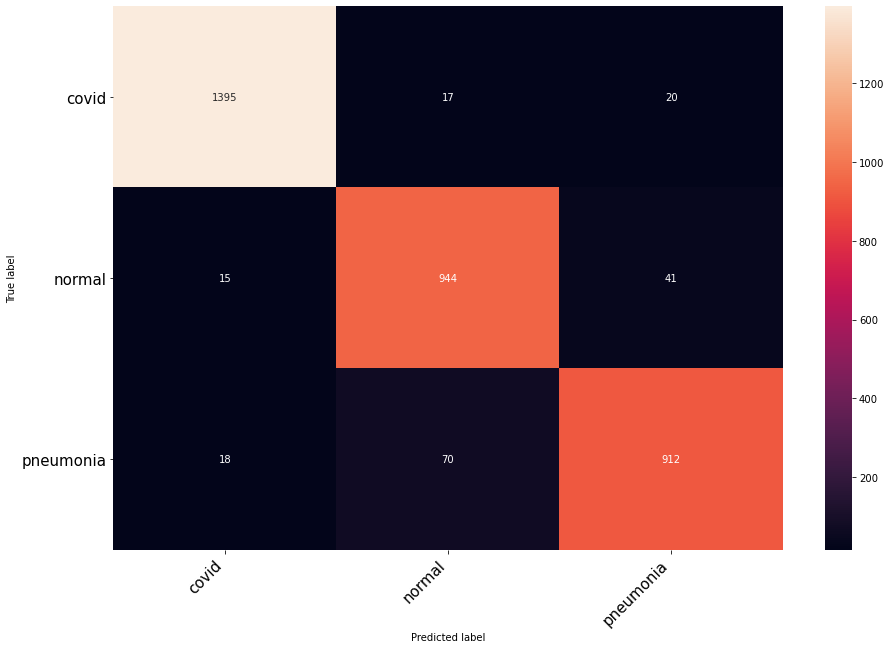

In [35]:
plt.figure(figsize=(15,10))

class_names = data_loader['valid'].dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Densenet_100epochs.png")

Text(0.5, 69.0, 'Predicted label')

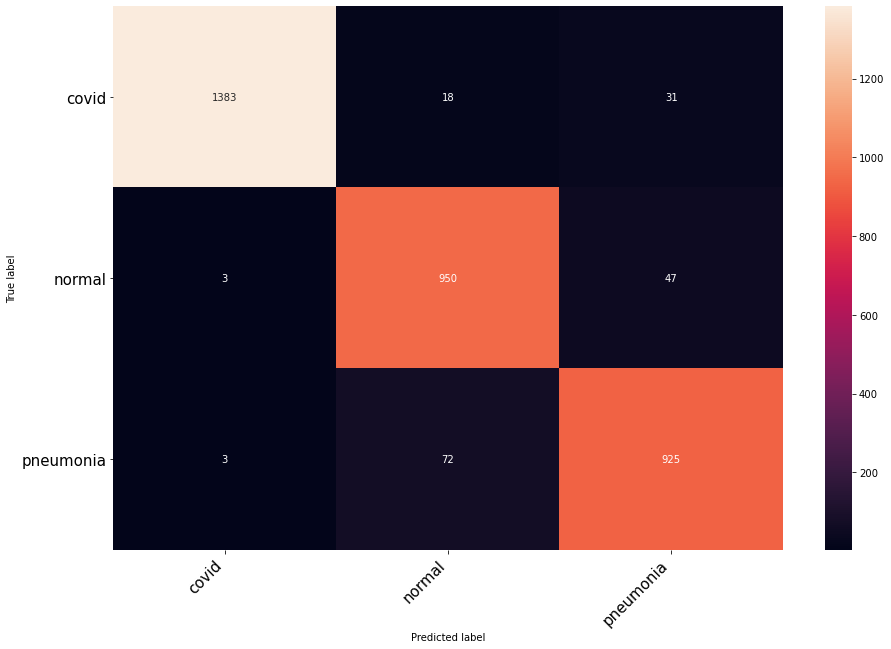

In [29]:
plt.figure(figsize=(15,10))

class_names = data_loader['valid'].dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Densenet_100epochs.png")

### Evaluation

In [19]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import time
model.eval()

class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform):
        filenames = os.listdir(image_loc)
        self.full_filenames = [os.path.join(image_loc,f) for f in filenames]
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

test_data = covid_dataset(image_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/",
                         label_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv",
                         transform = data_transforms['test'])

def deploy_model(model, dataset, device, num_classes = 3, sanity_check = False):
    len_data = len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)
    elapsed_times=[]
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
#             y_gt[i] = y
            start=time.time()
            y_out[i]=torch.exp(model(x.unsqueeze(0).to(device)))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms "%(device,inference_time))
    return y_out.numpy(),y_gt
        

In [20]:
y_test_out,_=deploy_model(model,test_data, device,sanity_check=False)

  0%|          | 0/1200 [00:00<?, ?it/s]

average inference time per image on cuda: 35.51 ms 


In [21]:
y_test_pred=np.argmax(y_test_out,axis=1)
np.unique(y_test_pred, return_counts=True)



(array([0, 1, 2]), array([389, 436, 375]))